In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [65]:
# get metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## Schema & Metadata

This section generates structured metadata for the dataset:
- Dataset size (number of rows and columns)
- For each column: data type, non-null/null counts, number of unique values
- Example values (up to 3 frequent values)
- For numeric columns: min, max, mean
- Per-column memory usage (deep=True)

Notes:
- The code will only display the metadata as output in the notebook.
- No files will be written to disk.

In [66]:
# Generate and display schema metadata (no file output)
import json
import numpy as np
import pandas as pd

# Dataset size
n_rows, n_cols = df.shape
print(f"Rows: {n_rows}, Columns: {n_cols}")

def safe_float(x):
    """Convert to float if possible, else return None (for JSON/printing friendliness)."""
    try:
        return float(x)
    except Exception:
        return None

columns_meta = []
for col in df.columns:
    s = df[col]
    dtype = str(s.dtype)
    non_null = int(s.notna().sum())
    nulls = int(s.isna().sum())
    n_unique = int(s.nunique(dropna=True))
    # Example values (top 3 by frequency)
    examples = (s.dropna()
                  .astype(str)
                  .value_counts()
                  .head(3)
                  .index
                  .tolist())
    # Numeric statistics
    if pd.api.types.is_numeric_dtype(s):
        min_v = safe_float(np.nanmin(s)) if non_null > 0 else None
        max_v = safe_float(np.nanmax(s)) if non_null > 0 else None
        mean_v = safe_float(np.nanmean(s)) if non_null > 0 else None
    else:
        min_v = max_v = mean_v = None
    mem_bytes = int(s.memory_usage(deep=True))
    columns_meta.append({
        "name": col,
        "dtype": dtype,
        "non_null": non_null,
        "nulls": nulls,
        "unique": n_unique,
        "examples": examples,
        "min": min_v,
        "max": max_v,
        "mean": mean_v,
        "memory_bytes": mem_bytes,
    })

meta = {
    "n_rows": int(n_rows),
    "n_cols": int(n_cols),
    "columns": columns_meta,
}

# Display as a table
pd.DataFrame(columns_meta)

Rows: 200, Columns: 5


,name,dtype,non_null,nulls,unique,examples,min,max,mean,memory_bytes
0,CustomerID,int64,200,0,200,"[1, 2, 3]",1.0,200.0,100.50,1732
1,Genre,object,200,0,2,"[Female, Male]",NaN,NaN,NaN,10956
2,Age,int64,200,0,51,"[32, 35, 31]",18.0,70.0,38.85,1732
3,Annual Income (k$),int64,200,0,64,"[54, 78, 60]",15.0,137.0,60.56,1732
4,Spending Score (1-100),int64,200,0,84,"[42, 55, 73]",1.0,99.0,50.20,1732


## Cleaning, Scaling, and Feature Selection

In [67]:
df.drop('CustomerID', axis=1, inplace=True)
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [68]:
df.isnull().sum()

Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [69]:
# encoding binary data with 0 (female) and 1 (male)
df['Genre'] = df['Genre'].map({'Female': 0, 'Male': 1})
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [70]:
# handling duplicates
df.duplicated().sum()

np.int64(0)

In [71]:
# feature engineering: creating age groups by one hot encoding
bins = [0, 25, 45, 65, 1000]
labels = ['<=24', '25-44', '45-64', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
age_dummies = pd.get_dummies(df['AgeGroup'], prefix='AgeGroup')
df = pd.concat([df, age_dummies], axis=1)
df.drop('AgeGroup', axis=1, inplace=True)
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),AgeGroup_<=24,AgeGroup_25-44,AgeGroup_45-64,AgeGroup_65+
0,1,19,15,39,True,False,False,False
1,1,21,15,81,True,False,False,False
2,0,20,16,6,True,False,False,False
3,0,23,16,77,True,False,False,False
4,0,31,17,40,False,True,False,False


## Practical Feature Engineering

We add a few interpretable features to better reflect customer profiles:
- Income_per_Age: annual income divided by age
- Spend_to_Income: spending score divided by annual income
- Age_Sq: squared age to capture non-linear effects
- Income_x_Score: interaction between income and spending score
- Income bins (quartiles) as one-hot dummies

Note: features are created before scaling; binary/dummy variables will not be scaled later.

In [79]:
# Create engineered features before scaling
import numpy as np
import pandas as pd

# Guard against division by zero
eps = 1e-9

if all(col in df.columns for col in ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']):
    df['Income_per_Age'] = df['Annual Income (k$)'] / (df['Age'] + eps)
    df['Spend_to_Income'] = df['Spending Score (1-100)'] / (df['Annual Income (k$)'] + eps)
    df['Age_Sq'] = df['Age'] ** 2
    df['Income_x_Score'] = df['Annual Income (k$)'] * df['Spending Score (1-100)']
    # Income bins (quartiles) -> dummies
    try:
        income_bins = pd.qcut(df['Annual Income (k$)'], q=4, labels=['Q1','Q2','Q3','Q4'])
        income_dummies = pd.get_dummies(income_bins, prefix='IncomeBin')
        df = pd.concat([df, income_dummies], axis=1)
    except Exception as e:
        print('Income binning skipped:', e)
else:
    print('Required base columns not found for feature engineering.')

df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),AgeGroup_<=24,AgeGroup_25-44,AgeGroup_45-64,AgeGroup_65+,Income_per_Age,Spend_to_Income,Age_Sq,Income_x_Score,IncomeBin_Q1,IncomeBin_Q2,IncomeBin_Q3,IncomeBin_Q4
0,1,-1.424569,-1.738999,-0.434801,True,False,False,False,1.220720,0.250030,2.029396,0.756119,True,False,False,False
1,1,-1.281035,-1.738999,1.195704,True,False,False,False,1.357495,-0.687582,1.641052,-2.079328,True,False,False,False
2,0,-1.352802,-1.700830,-1.715913,True,False,False,False,1.257264,1.008868,1.830074,2.918476,True,False,False,False
3,0,-1.137502,-1.700830,1.040418,True,False,False,False,1.495232,-0.611712,1.293911,-1.769574,True,False,False,False
4,0,-0.563369,-1.662660,-0.395980,False,True,False,False,2.951284,0.238160,0.317384,0.658380,True,False,False,False


In [80]:
# scaling using standard scaler (exclude binary/dummy features)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Select numeric columns with >2 unique values (exclude binary/dummies like Genre or IncomeBin_*)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
binary_like = [c for c in num_cols if df[c].nunique(dropna=True) <= 2]
scale_cols = [c for c in num_cols if c not in binary_like]

df[scale_cols] = scaler.fit_transform(df[scale_cols])
print('Scaled columns:', scale_cols[:10], '... (total', len(scale_cols), ')')
df.head()

Scaled columns: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_per_Age', 'Spend_to_Income', 'Age_Sq', 'Income_x_Score'] ... (total 7 )


,Genre,Age,Annual Income (k$),Spending Score (1-100),AgeGroup_<=24,AgeGroup_25-44,AgeGroup_45-64,AgeGroup_65+,Income_per_Age,Spend_to_Income,Age_Sq,Income_x_Score,IncomeBin_Q1,IncomeBin_Q2,IncomeBin_Q3,IncomeBin_Q4
0,1,-1.424569,-1.738999,-0.434801,True,False,False,False,0.134609,0.068713,0.897591,0.617240,True,False,False,False
1,1,-1.281035,-1.738999,1.195704,True,False,False,False,0.154910,-0.263947,0.558971,-1.728128,True,False,False,False
2,0,-1.352802,-1.700830,-1.715913,True,False,False,False,0.140033,0.337945,0.723790,2.405855,True,False,False,False
3,0,-1.137502,-1.700830,1.040418,True,False,False,False,0.175353,-0.237029,0.256278,-1.471912,True,False,False,False
4,0,-0.563369,-1.662660,-0.395980,False,True,False,False,0.391461,0.064502,-0.595213,0.536394,True,False,False,False


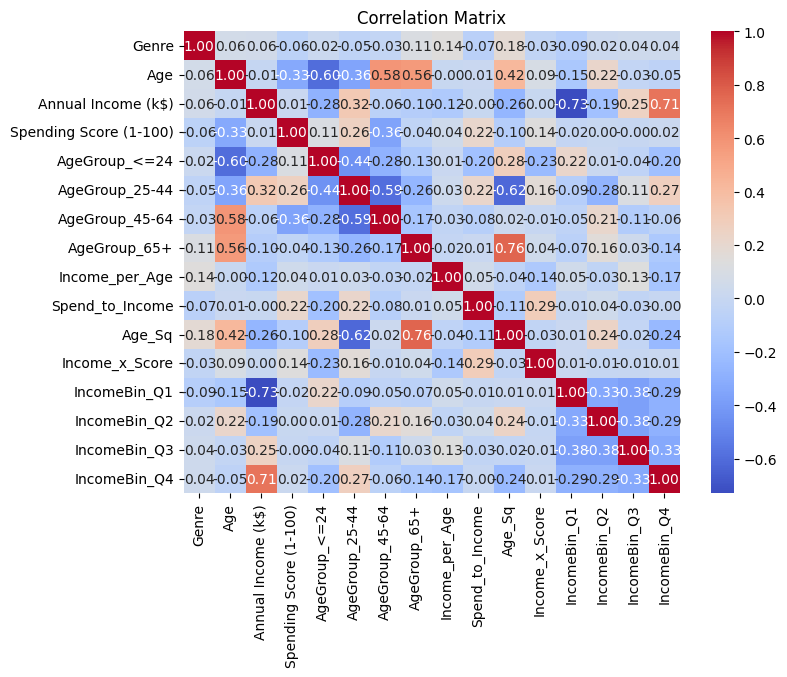

[[ 1.00000000e+00  6.08673870e-02  5.64098099e-02 -5.81087393e-02
   1.59057776e-02 -4.51622302e-02 -2.70704546e-02  1.12118557e-01
   1.44731063e-01 -6.93745227e-02  1.78070913e-01 -2.92241690e-02
  -9.30484210e-02  2.32621053e-02  3.51689974e-02  3.52547547e-02]
 [ 6.08673870e-02  1.00000000e+00 -1.23980427e-02 -3.27226846e-01
  -5.95667876e-01 -3.55242355e-01  5.83638206e-01  5.61285925e-01
  -4.65707789e-11  1.07370484e-02  4.20214030e-01  9.40279523e-02
  -1.47921228e-01  2.22503360e-01 -2.58402798e-02 -5.11337664e-02]
 [ 5.64098099e-02 -1.23980427e-02  1.00000000e+00  9.90284809e-03
  -2.79565047e-01  3.18679692e-01 -6.31720184e-02 -9.71188837e-02
  -1.24398466e-01 -1.99965827e-11 -2.60250682e-01  3.11251580e-03
  -7.30751238e-01 -1.94808231e-01  2.52542930e-01  7.12623243e-01]
 [-5.81087393e-02 -3.27226846e-01  9.90284809e-03  1.00000000e+00
   1.08301097e-01  2.59458032e-01 -3.61250676e-01 -3.71255010e-02
   4.11197476e-02  2.15103402e-01 -1.01886915e-01  1.36495332e-01
  -1.61

In [81]:
# Feature Selection using Correlation Matrix
plt.figure(figsize=(8, 6))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
print(correlation_matrix.to_numpy())

In [82]:
# 1) Filter: Variance and Correlation pruning
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

# Consider numeric columns only for clustering
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X_num = df[numeric_cols].copy()

# Near-zero variance removal (keep binary dummies)
vt = VarianceThreshold(threshold=1e-8)
X_vt = vt.fit_transform(X_num)
kept_by_variance = [c for c, keep in zip(numeric_cols, vt.get_support()) if keep]

# Correlation-based redundancy removal
corr = pd.DataFrame(X_vt, columns=kept_by_variance).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
corr_threshold = 0.90
to_drop = [col for col in upper.columns if any(upper[col] > corr_threshold)]
kept_by_corr = [c for c in kept_by_variance if c not in to_drop]

print("Numeric columns:", numeric_cols)
print("Kept after variance:", kept_by_variance)
print("Dropped due to high correlation (>", corr_threshold, "):", to_drop)
print("Kept after correlation:", kept_by_corr)

Numeric columns: ['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_per_Age', 'Spend_to_Income', 'Age_Sq', 'Income_x_Score']
Kept after variance: ['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_per_Age', 'Spend_to_Income', 'Age_Sq', 'Income_x_Score']
Dropped due to high correlation (> 0.9 ): []
Kept after correlation: ['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_per_Age', 'Spend_to_Income', 'Age_Sq', 'Income_x_Score']


In [83]:
# 2) Wrapper: Greedy forward selection maximizing silhouette
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from itertools import combinations

def eval_subset(cols, k_range=range(2, 9)):
    if len(cols) == 0:
        return -1.0, None
    X = df[cols].to_numpy()
    Xs = StandardScaler().fit_transform(X)
    best_s, best_k = -1.0, None
    # Avoid trivial perfect separation for single feature by requiring k>=3 when dim==1
    k_candidates = [k for k in k_range if not (Xs.shape[1] == 1 and k <= 3)]
    for k in k_candidates:
        if k >= len(Xs):
            continue
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(Xs)
        if len(set(labels)) < 2:
            continue
        s = silhouette_score(Xs, labels, metric='euclidean')
        if s > best_s:
            best_s, best_k = s, k
    return best_s, best_k

remaining = kept_by_corr.copy()
selected = []
best_score = -1.0
improve_tol = 1e-4

# First step: pick the best pair to avoid degenerate 1D solutions
if len(remaining) >= 2:
    pair_scores = []
    for f1, f2 in combinations(remaining, 2):
        s, k = eval_subset([f1, f2])
        pair_scores.append((s, (f1, f2), k))
    pair_scores.sort(reverse=True)  # by score desc
    best_pair_s, (f1_best, f2_best), best_k = pair_scores[0]
    selected = [f1_best, f2_best]
    remaining = [f for f in remaining if f not in selected]
    best_score = best_pair_s

while len(remaining) > 0:
    candidates = []
    for f in remaining:
        s, k = eval_subset(selected + [f])
        candidates.append((s, f, k))
    candidates.sort(reverse=True)  # sort by score desc
    top_s, top_f, top_k = candidates[0]
    if top_s > best_score + improve_tol:
        selected.append(top_f)
        remaining.remove(top_f)
        best_score = top_s
        best_k = top_k
    else:
        break

print("Wrapper-selected features:", selected)
print("Best silhouette:", round(best_score, 4), "with k=", best_k)

Wrapper-selected features: ['Income_per_Age', 'Spend_to_Income']
Best silhouette: 0.8259 with k= 2


In [84]:
# 3) Embedded: RandomForest importances on pseudo labels (from KMeans) + aggregation
from sklearn.ensemble import RandomForestClassifier
from math import ceil

# Use wrapper-selected features; fallback to kept_by_corr if empty
wrapper_selected = selected if len(selected) > 0 else []
filter_kept = kept_by_corr.copy()
base_feats = wrapper_selected if len(wrapper_selected) > 0 else filter_kept
if len(base_feats) == 0:
    print("No features available after filtering; please check preprocessing.")
else:
    # Determine k by best silhouette on the base features
    s_base, k_use = eval_subset(base_feats)
    if k_use is None:
        k_use = 5
    print("Using k=", k_use, "for pseudo labels (best silhouette:", round(s_base, 4), ")")
    # Pseudo labels via KMeans
    Xb = df[base_feats].to_numpy()
    Xb_s = StandardScaler().fit_transform(Xb)
    km = KMeans(n_clusters=k_use, n_init=10, random_state=42)
    y_pseudo = km.fit_predict(Xb_s)
    # Train RandomForest to rank features
    rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    rf.fit(Xb, y_pseudo)
    importances = rf.feature_importances_
    feat_importances = sorted(zip(base_feats, importances), key=lambda x: x[1], reverse=True)
    print("Feature importances (desc):")
    for f, w in feat_importances:
        print(f"  {f}: {w:.4f}")
    # Keep top-N by importance (N = max(2, ceil(len(base_feats)/2)))
    top_n = max(2, ceil(len(base_feats)/2))
    embedded_top = [f for f, _ in feat_importances[:top_n]]
    # Aggregate three methods
    filter_set = set(filter_kept)
    wrapper_set = set(wrapper_selected)
    embedded_set = set(embedded_top)
    final_union = sorted(filter_set | wrapper_set | embedded_set)
    final_intersection = sorted(filter_set & wrapper_set & embedded_set)
    final_majority = sorted([f for f in final_union if (int(f in filter_set) + int(f in wrapper_set) + int(f in embedded_set)) >= 2])
    print("\nFilter kept:", sorted(filter_set))
    print("Wrapper selected:", sorted(wrapper_set))
    print("Embedded top:", embedded_top)
    print("\nFinal (union):", final_union)
    print("Final (intersection):", final_intersection)
    print("Final (majority vote >=2):", final_majority)

Using k= 2 for pseudo labels (best silhouette: 0.8259 )


Feature importances (desc):
  Income_per_Age: 0.8198
  Spend_to_Income: 0.1802

Filter kept: ['Age', 'Age_Sq', 'Annual Income (k$)', 'Genre', 'Income_per_Age', 'Income_x_Score', 'Spend_to_Income', 'Spending Score (1-100)']
Wrapper selected: ['Income_per_Age', 'Spend_to_Income']
Embedded top: ['Income_per_Age', 'Spend_to_Income']

Final (union): ['Age', 'Age_Sq', 'Annual Income (k$)', 'Genre', 'Income_per_Age', 'Income_x_Score', 'Spend_to_Income', 'Spending Score (1-100)']
Final (intersection): ['Income_per_Age', 'Spend_to_Income']
Final (majority vote >=2): ['Income_per_Age', 'Spend_to_Income']


In [85]:
# Operate union directly on df
df = df[final_union]
df.head()

,Age,Age_Sq,Annual Income (k$),Genre,Income_per_Age,Income_x_Score,Spend_to_Income,Spending Score (1-100)
0,-1.424569,0.897591,-1.738999,1,0.134609,0.617240,0.068713,-0.434801
1,-1.281035,0.558971,-1.738999,1,0.154910,-1.728128,-0.263947,1.195704
2,-1.352802,0.723790,-1.700830,0,0.140033,2.405855,0.337945,-1.715913
3,-1.137502,0.256278,-1.700830,0,0.175353,-1.471912,-0.237029,1.040418
4,-0.563369,-0.595213,-1.662660,0,0.391461,0.536394,0.064502,-0.395980


In [87]:
df.to_csv('Preprocessed_Data.csv')

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Age_Sq                  200 non-null    float64
 2   Annual Income (k$)      200 non-null    float64
 3   Genre                   200 non-null    int64  
 4   Income_per_Age          200 non-null    float64
 5   Income_x_Score          200 non-null    float64
 6   Spend_to_Income         200 non-null    float64
 7   Spending Score (1-100)  200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB
